In [1]:
import pickle
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
os.chdir('..')
from star_sample import Isochrones,StarSample
os.chdir('Data')
pkl_file = open('isochrones_cluster.pkl', 'rb')
Isochrone_cluster = pickle.load(pkl_file)

pkl_file = open('cluster_values.pkl', 'rb')
Cluster_sample = pickle.load(pkl_file)


os.chdir('..')

# Perpendicular Distance

We want to check the perpendicular distance from the isochrone to see if it is giving us something reasonable.

Add on the absolute magnitude

In [2]:
Cluster_sample.mean_absolute_mag_g_band(abs_column_name='G',magnitude_column='phot_g_mean_mag',parallax_column='parallax')

Need to do the column index stuff.

In [3]:

Cluster_sample.data['G']=Cluster_sample.data['phot_g_mean_mag']-5*np.log10((Cluster_sample.data['rgeo']*1000.0)/10.0)

In [4]:
Cluster_sample.data['G']=Cluster_sample.data['G']-1.2
Cluster_sample.data['bp_rp']=Cluster_sample.data['bp_rp']-0.6

In [5]:
#Cluster_sample.data=Cluster_sample.data[Cluster_sample.data['G']<=4.5].reset_index(drop=True)
Cluster_sample.data=Cluster_sample.data[Cluster_sample.data['G']>=1.5].reset_index(drop=True)

In [6]:
stacked_isochrones=Isochrone_cluster.stack_isochrones()#_subsample(feh_list,age_list)


In [7]:
x_values=Cluster_sample.to_tensor(expandsize=stacked_isochrones.shape[-2])

In [8]:
age_list=[8.5]
feh_list=[0.17 for i in range(len(x_values))]#Cluster_sample.data['mh_gspphot']
stacked_isochrones=Isochrone_cluster.stack_isochrones_subsample(feh_list,age_list)

In [9]:
x_columns=Cluster_sample.data.columns
isoc_columns=Isochrone_cluster.isochrones_list[0].columns
def column_index(name):
    if name in x_columns:
        return np.where(np.array(x_columns)==name)[0][0]
    else:
        return np.where(np.array(isoc_columns)==name)[0][0] +len(x_columns)

In [10]:
Isochrone_cluster.isochrones_list[Isochrone_cluster.isochrone_selector(torch.tensor([0.17]),torch.tensor([8.5]))]

,logg,logteff,logl,mass,logage,feh,phase,Gaia_BP_EDR3,Gaia_RP_EDR3,Gaia_G_EDR3,BPRP,p_slopes,slopes,low_c,high_c
0,4.942026,3.515330,-1.968973,0.330330,8.444444,0.17,0.0,12.135543,9.520765,10.691293,2.614778,-0.393466,2.541514,11.479872,11.720120
1,4.932868,3.522222,-1.906692,0.350350,8.444444,0.17,0.0,11.866876,9.333954,10.483252,2.532921,-0.416017,2.403750,11.278493,11.536990
2,4.923132,3.529938,-1.841957,0.370370,8.444444,0.17,0.0,11.578593,9.137344,10.262893,2.441248,-0.430414,2.323342,11.043899,11.313642
3,4.912914,3.538185,-1.775891,0.390390,8.444444,0.17,0.0,11.278403,8.935109,10.035312,2.343294,-0.379290,2.636503,10.694005,10.924100
4,4.899268,3.544742,-1.714800,0.410410,8.444444,0.17,0.0,11.021094,8.754097,9.834155,2.266997,-0.314378,3.180882,10.346578,10.546850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,3.640430,3.992142,2.235501,3.273273,8.444444,0.17,0.0,-0.658726,-0.608414,-0.641239,-0.050312,0.085945,-11.635411,-0.689463,-0.636915
148,3.615098,3.988919,2.250569,3.293293,8.444444,0.17,0.0,-0.709388,-0.663560,-0.693402,-0.045828,0.104747,-9.546775,-0.742815,-0.688601
149,3.588161,3.985323,2.265750,3.313313,8.444444,0.17,0.0,-0.761133,-0.720922,-0.747027,-0.040211,0.109809,-9.106750,-0.798858,-0.742612
150,3.559645,3.981377,2.281109,3.333333,8.444444,0.17,0.0,-0.814663,-0.780555,-0.802604,-0.034108,0.112753,-8.868974,-0.856933,-0.798758


In [11]:
x_values.shape

torch.Size([739, 218, 25])

In [12]:
stacked_isochrones.shape

torch.Size([739, 218, 15])

In [13]:

isochrone=torch.cat([x_values,stacked_isochrones],dim=-1)
#this line is only for single sample isochrone=isochrone.reshape((1,)+isochrone.shape)
isochrone.shape

torch.Size([739, 218, 40])

In [14]:
# taking the minimum

truth_1=(isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')]<=isochrone[:,:,column_index('high_c')]) #box selection
truth_2=(isochrone[:,:,column_index('low_c')]<=isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')])
truth=torch.logical_and(truth_1,truth_2)


# projection onto the nearest line
x=((1/torch.sqrt(1+isochrone[:,:,column_index('slopes')]**2))*(isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('slopes')]-isochrone[:,:,column_index('Gaia_G_EDR3')] + isochrone[:,:,column_index('slopes')]*isochrone[:,:,column_index('BPRP')]))

print(x.shape)
idx=torch.argmin(torch.abs(x/truth.reshape(x.shape)).nan_to_num(nan=torch.inf),-1)
x=x.gather(1,idx.view(-1,1))
#error needs to be corrected for absolute magnitude 
x_err=(1/(1+isochrone[:,:,column_index('slopes')]**2))*isochrone[:,:,column_index('phot_g_mean_mag_error')]**2+(isochrone[:,:,column_index('slopes')]*isochrone[:,:,column_index('bp_rp_error')])**2
x_err=x_err.gather(1,idx.view(-1,1))

         

torch.Size([739, 218])


In [15]:
Cluster_sample.data['perp']=np.array(x)

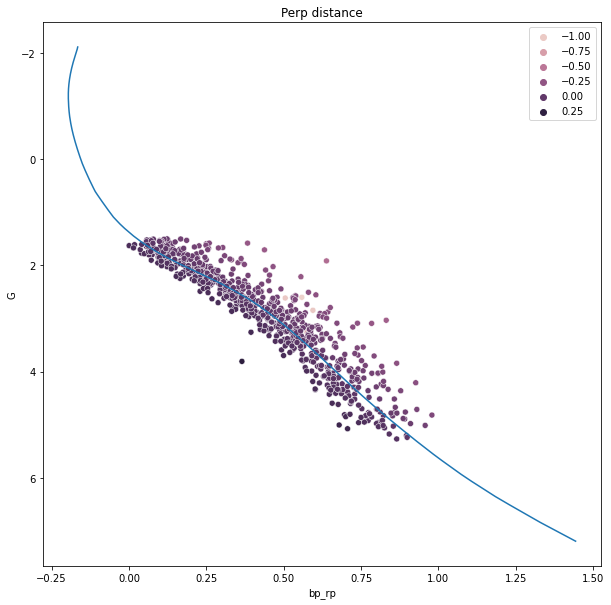

In [16]:
title='Perp distance'
mag_column='G'
colour_column='bp_rp'
hue_column='perp'
height=10
width=10
isochrone=Isochrone_cluster.isochrones_list[0]
f, axes = plt.subplots(1, 1)
f.set_figheight(height)
f.set_figwidth(width)
plt.plot(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3'], isochrone['Gaia_G_EDR3'],
                                )
sn.scatterplot(x=Cluster_sample.data[colour_column],y=Cluster_sample.data[mag_column],hue=Cluster_sample.data[hue_column])#,kwargs=kwargs)
axes.invert_yaxis()
plt.legend()
axes.set_title(title)
plt.show()

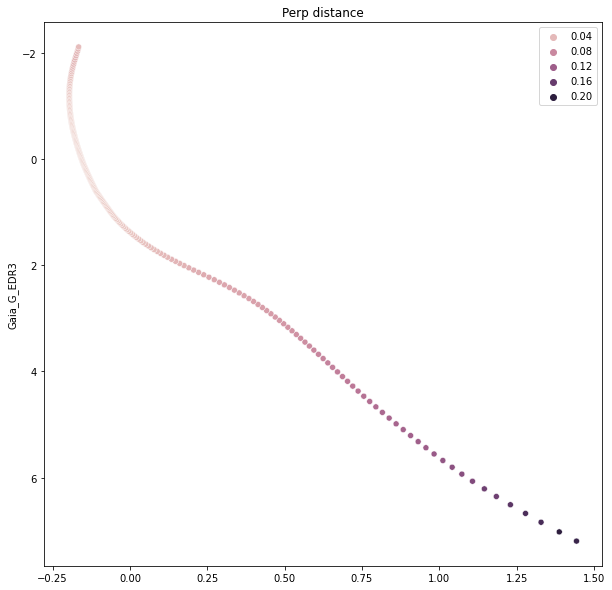

In [17]:
title='Perp distance'
mag_column='G'
colour_column='bp_rp'
hue_column='perp'
height=10
width=10
isochrone=Isochrone_cluster.isochrones_list[0]

f, axes = plt.subplots(1, 1)
f.set_figheight(height)
f.set_figwidth(width)
#sn.scatterplot(x=(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3']), y=isochrone['Gaia_G_EDR3']
#                              )

sn.scatterplot(x=(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3']), y=isochrone['Gaia_G_EDR3'], hue=(isochrone['high_c']-isochrone['low_c'])
                              )
#sn.scatterplot(x=Cluster_sample.data[colour_column],y=Cluster_sample.data[mag_column],hue=Cluster_sample.data[hue_column])#,kwargs=kwargs)
axes.invert_yaxis()
plt.legend()
axes.set_title(title)
plt.show()

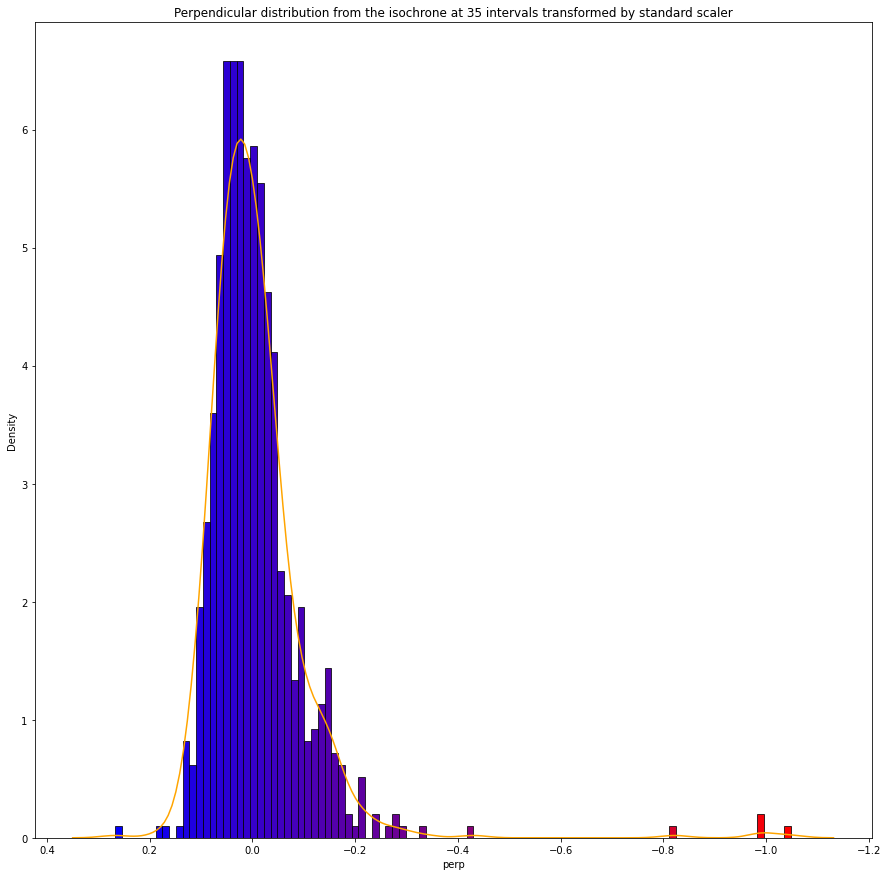

In [18]:

f, ax = plt.subplots(1, 1, figsize=(15,15))
plt.title('Perpendicular distribution from the isochrone at 35 intervals transformed by standard scaler')
sn.histplot(Cluster_sample.data['perp'],ax=ax,kde=False,legend=False,bins=100,stat='density')
for i in range(0,100):
    ax.patches[i].set_facecolor([1-i/100,0,i/100])
sn.kdeplot(Cluster_sample.data['perp'],ax=ax,color='orange')
ax.invert_xaxis()
plt.show()